# Deep Learning with PyTorch : Build a Generative Adversarial Network

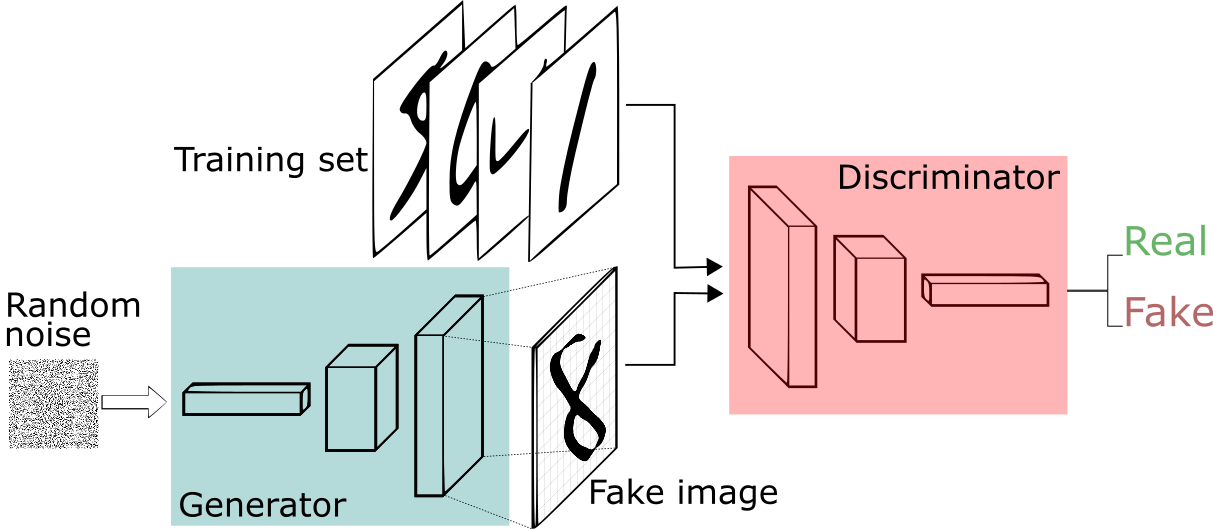

In [1]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [2]:
device = 'cuda'

batch_size = 128 #train loader, training loop

noise_dim = 64 # generator model

#optimizers parameters

lr = 0.0002

beta_1 = 0.5
beta_2 = 0.99

#Training variables

epochs = 20


# Load MNIST Dataset

In [3]:
from torchvision import datasets, transforms as T


In [4]:
train_augs = T.Compose([
    T.RandomRotation((-20, 20)),
    T.ToTensor()
])

In [5]:
trainset = datasets.MNIST(root = './data', train = True, download = True, transform = train_augs)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.87MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.37MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



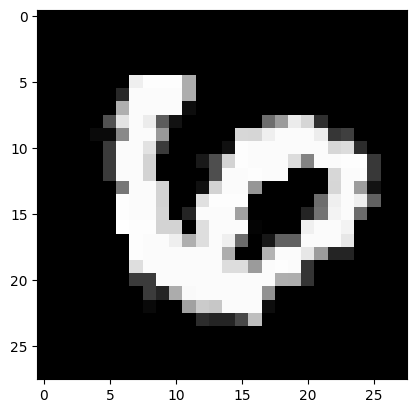

In [6]:
image, label = trainset[9000]

plt.imshow(image.squeeze(), cmap = 'gray')

# Load Dataset Into Batches

In [7]:
from torch.utils.data import dataloader
from torchvision.utils import make_grid

In [8]:
trainloader = dataloader.DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [9]:
print("total no of batches in trainloader : ", len(trainloader))

total no of batches in trainloader :  469


In [10]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
print("shape of images : ", images.shape)

shape of images :  torch.Size([128, 1, 28, 28])


In [11]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

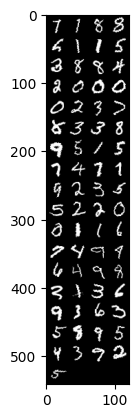

In [12]:
show_tensor_images(images, num_images=69)

# Create Discriminator Network

In [13]:
#In case if torch summary is not installed

!pip install torchsummary

In [14]:
from torch import nn
from torchsummary import summary

In [15]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [16]:
def get_disc_block(input_channels, output_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(input_channels, output_channels, kernel_size, stride),
      nn.BatchNorm2d(output_channels),
      nn.LeakyReLU(0.2)
  )

In [17]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.block_1 = get_disc_block(1, 16, 3, 2)
    self.block_2 = get_disc_block(16, 32, 5, 2)
    self.block_3 = get_disc_block(32, 64, 5, 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(64, 1)
  def forward(self, images):
    x = self.block_1(images)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.flatten(x)
    x = self.linear(x)
    return x

In [18]:
D = Discriminator().to(device)
summary(D, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [19]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [20]:
def get_gen_block(input_channels, output_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
        nn.BatchNorm2d(output_channels),
        nn.ReLU()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
      nn.BatchNorm2d(output_channels),
      nn.ReLU()
  )

In [21]:
class Generator(nn.Module):
  def __init__(self, z_dim):
    super(Generator, self).__init__()
    self.z_dim = z_dim
    self.block_1 = get_gen_block(z_dim,256,(3,3),1)
    self.block_2 = get_gen_block(256, 128, (4,4),1)
    self.block_3 = get_gen_block(128,64, (3,3),2)

    self. block_4 = get_gen_block(64,1,(4,4),2, final_block = True)

  def forward(self, r_noise_vec):
      x = r_noise_vec.view(-1, self.z_dim, 1,1)

      x1 = self.block_1(x)
      x2 = self.block_2(x1)
      x3 = self.block_3(x2)
      x4 = self.block_4(x3)

      return x4

In [23]:
G = Generator(noise_dim).to(device)
summary(G, (noise_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
      BatchNorm2d-11            [-1, 1, 28, 28]               2
             ReLU-12            [-1, 1, 28, 28]               0
Total params: 747,843
Trainable params: 747,843
Non-trainable params: 0
-------------------------------

In [24]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [26]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [27]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss


In [28]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.6676907515220805
Average Generator Loss :  0.7070022535476603


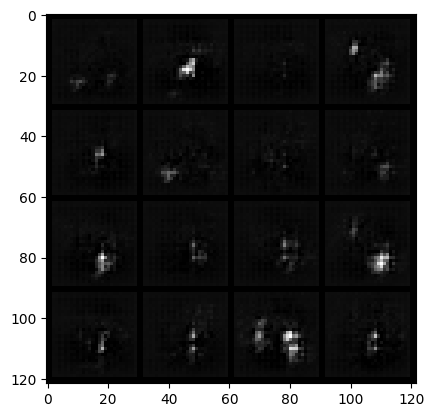

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.5810479797534088
Average Generator Loss :  0.8220389062153505


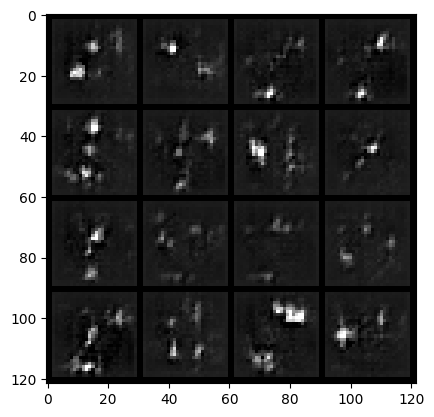

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.4886404125929387
Average Generator Loss :  0.9666273318755347


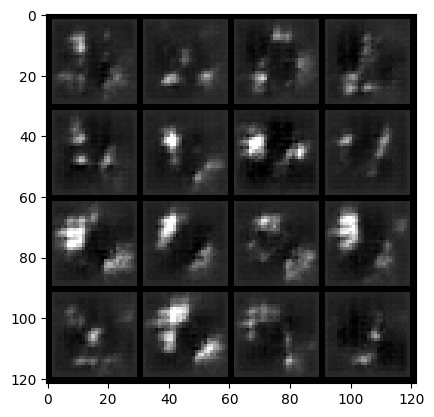

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.43996180133270557
Average Generator Loss :  1.086512435600956


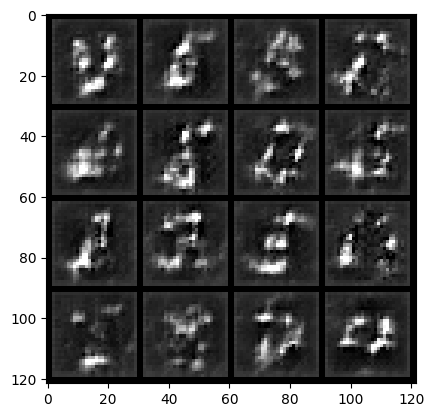

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.4847043337089929
Average Generator Loss :  1.0723630792931962


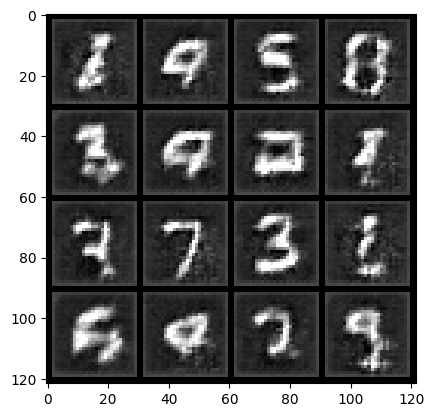

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.5704382121690047
Average Generator Loss :  0.8977449860399974


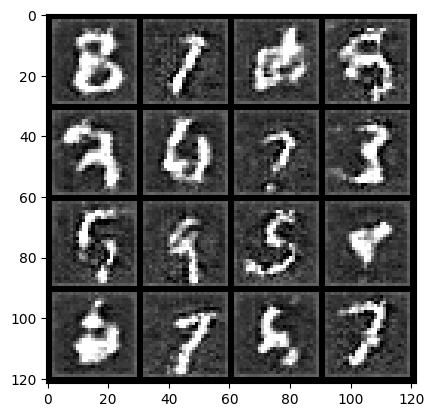

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.6726119874128654
Average Generator Loss :  0.7360578822428738


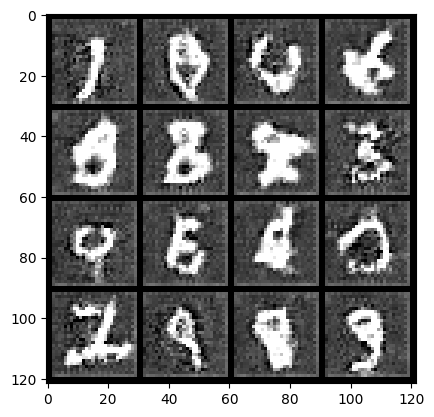

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.6360600693647795
Average Generator Loss :  0.8013708718549977


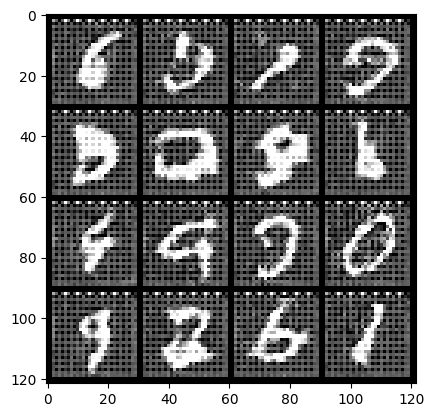

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.6234254543461016
Average Generator Loss :  0.8096336879964068


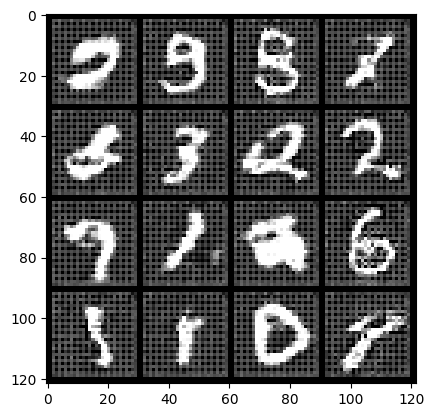

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.6305733361223868
Average Generator Loss :  0.8029083112028362


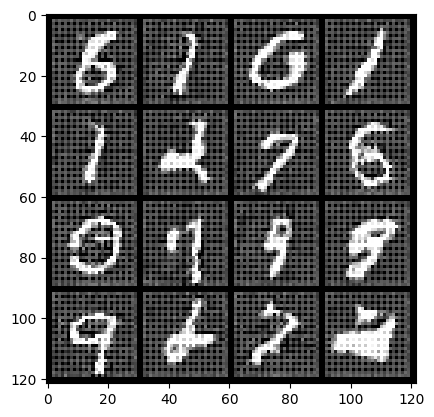

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.6366112602036645
Average Generator Loss :  0.797453493578856


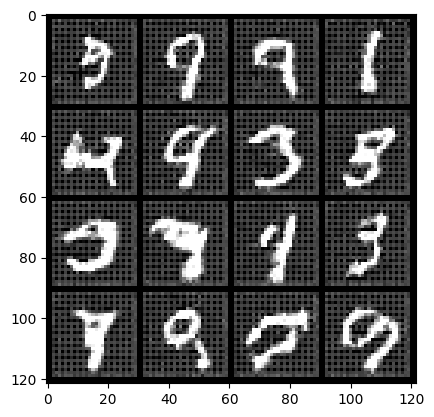

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.6360522098124408
Average Generator Loss :  0.803273011753554


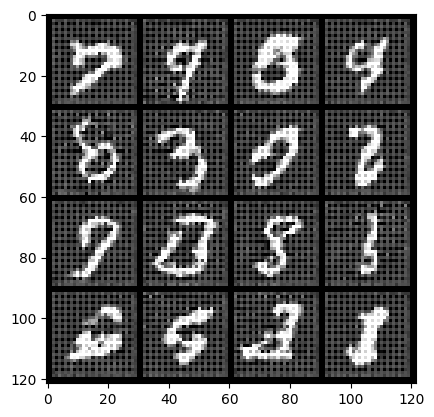

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.6378492869293766
Average Generator Loss :  0.8019759446573156


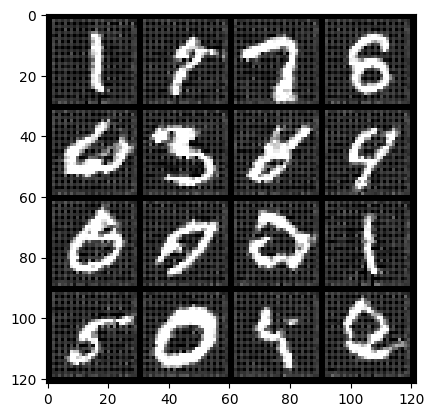

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.6375390199710057
Average Generator Loss :  0.8018849929258514


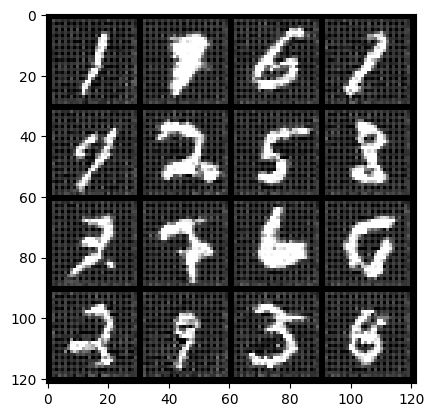

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.639736124320325
Average Generator Loss :  0.802107869943322


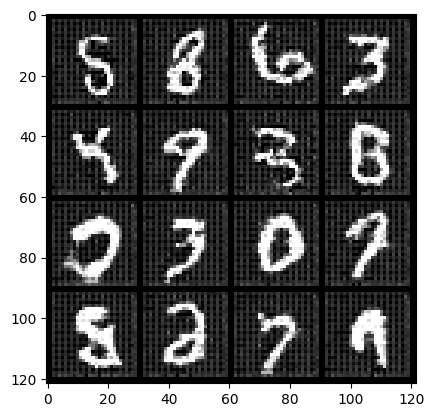

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.6415505242754401
Average Generator Loss :  0.8008074105294274


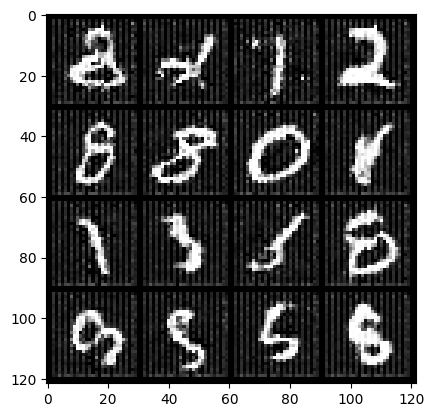

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.6440728943485187
Average Generator Loss :  0.8000203609974907


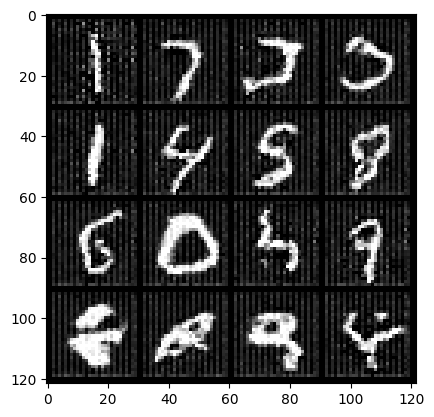

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.645183462832274
Average Generator Loss :  0.7978887490626337


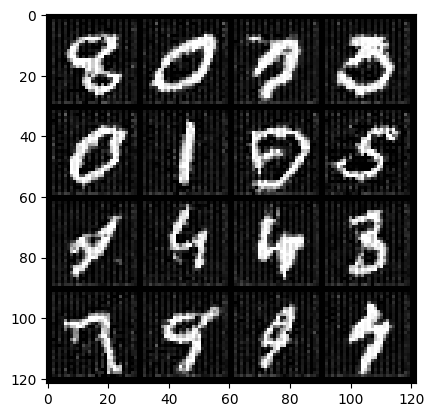

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.6479185437088582
Average Generator Loss :  0.7976432328285185


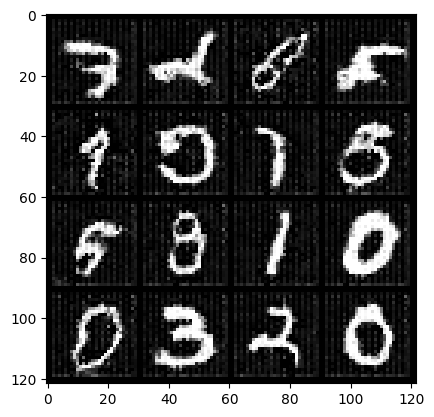

  0%|          | 0/469 [00:00<?, ?it/s]

Average Discriminator Loss :  0.6495832602606654
Average Generator Loss :  0.7946141289749633


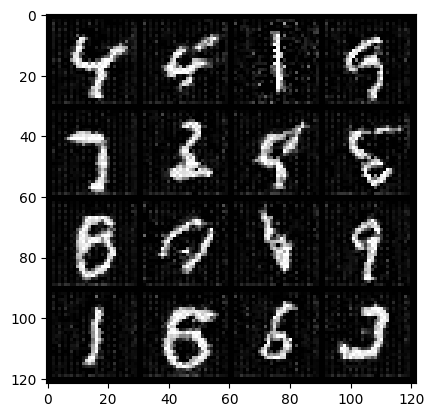

In [29]:
for i in range(epochs):
  total_D_loss = 0
  total_G_loss = 0

  for real_images, _ in tqdm(trainloader):
    real_images = real_images.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)

    D_opt.zero_grad()

    fake_images = G(noise)
    D_pred = D(fake_images)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_images)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2
    total_D_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    G_opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device = device)

    fake_img = G(noise)
    D_pred = D(fake_img)

    G_loss = real_loss(D_pred)
    total_G_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avgd_D_loss = total_D_loss/len(trainloader)
  avgd_G_loss = total_G_loss/len(trainloader)

  print("Average Discriminator Loss : ", avgd_D_loss)
  print("Average Generator Loss : ", avgd_G_loss)

  show_tensor_images(fake_images)


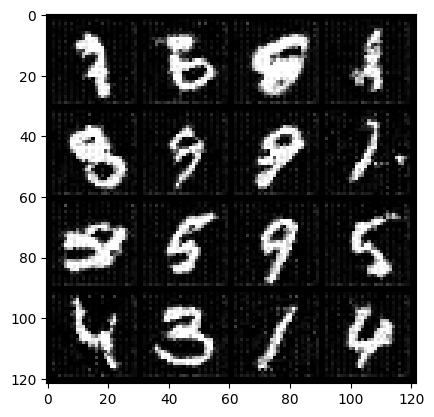

In [30]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)